<a href="https://www.kaggle.com/code/abhirupghosh184098/advanced-regression-a-beginner-s-perspective?scriptVersionId=113701878" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Competition: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

## [Short Description](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/description) (and Disclaimer)

This is a “getting started” competition, where we use information describing (almost) every aspect of residential homes in Ames, Iowa, to predict the final price of each home. I used this competition to explore two basic steps in a machine learning workflow using two excellent Kaggle learn courses:
* [Data cleaning](https://www.kaggle.com/learn/data-cleaning)
* [Feature Engineering](https://www.kaggle.com/learn/feature-engineering)

A lot of the code in this notebook are from these two courses. Specifically, we follow the logic of this bonus lesson: [Feature Engineering for House Prices](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices).

## [Evaluation](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation)
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$
where:

𝑛 is the total number of instances,  
𝑦̂ 𝑖 is the predicted value of the target for instance (i),  
𝑦𝑖 is the actual value of the target for instance (i), and,  
log is the natural logarithm.

## [Data](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

### Training set: train.csv
* **SalePrice**: the property's sale price in dollars and our target variable
* 78 explanatory variables describing (almost) every aspect of residential homes

### Test set: test.csv

### Data description: data_description.txt

Full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here

### Submission file: sample_submission.csv
a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

# 5 basic steps in a machine learning task

![](https://cdn-images-1.medium.com/max/1600/1*KzmIUYPmxgEHhXX7SlbP4w.jpeg)

[Source: [Noteworthy — The Journal Blog](https://medium.com/@maloojinesh/machine-learning-for-beginners-from-zero-level-8be5b89bf77c)]

In this notebook, we focus on the second step, "Clean, prepare and manipulate data", also referred to as **"Data Preprocessing/Preparation"**. There are several sub-steps, but we focus on:
* Data Cleaning
* Feature Engineering

Finally, we will use a few different models to make predictions. But the focus of this notebook is modelling.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Preliminaries

## Dependencies

In [2]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from fastai.tabular.all import *
import seaborn as sns


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

import warnings
warnings.simplefilter('ignore', FutureWarning)

# Mute warnings
warnings.filterwarnings('ignore')

# Data Preprocessing/Preparation

As part of our data preparation, we will [[source](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=3)]:
* **Clean** the data to fix any errors or inconsistencies
* **Encode** the statistical data type (numeric, categorical)
* **Impute** any missing values


## Clean-encode-impute

In [3]:
###################################
# Data cleaning
###################################
# Some of the categorical features in this dataset have what are apparently 
# typos in their categories

def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

###################################
# Data Encoding: Encode the Statistical Data Type
###################################

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

###################################
# Handle Missing Values
###################################

# impute 0 for missing numeric values and 
# "None" for missing categorical values.

def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Load data

In [4]:
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [5]:
df_train, df_test = load_data()

## Cover Photo

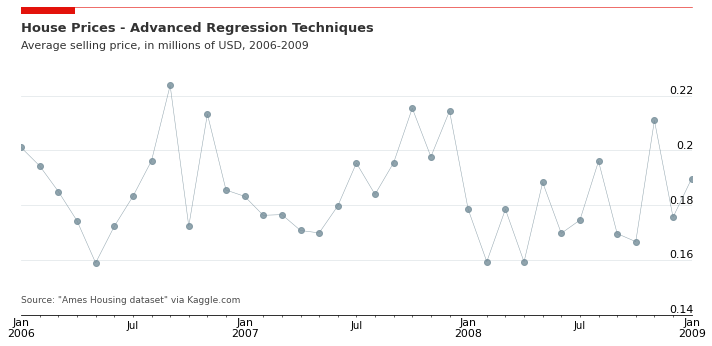

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

(df_train.groupby(['YrSold', 'MoSold']).agg({'SalePrice':'sum',
                         'MSSubClass':'count'})
         .reset_index()
         .assign(price_per_house = lambda x: x.SalePrice/x.MSSubClass/1e6,
                date = lambda x: pd.to_datetime((x.YrSold*10000+x.MoSold*100+1).apply(str),format='%Y%m%d'))
).set_index(['date']).loc[:'2009']['price_per_house'].plot(
            ax=ax, 
            color='#758D99', 
            alpha=0.8, 
            linewidth=0.5,
            marker='o',
            xlabel="")

# Create grid 
ax.grid(which="major", axis='y', color='#758D99', alpha=0.2, zorder=1)    

# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top','right','left']].set_visible(False)

# y-axis

## limits
ax.set_ylim(0.14, 0.23)

## ticks
ax.set_yticks(np.arange(0.14, 0.23, 0.02), minor=False)

## tick labels

ax.set_yticklabels([0.14, 0.16, 0.18, 0.2, 0.22],            # Set labels again
                   ha = 'right',                 # Set horizontal alignment to right
                   verticalalignment='bottom')   # Set vertical alignment to make labels on top of gridline


## tick label params
ax.yaxis.set_tick_params(pad=-2,         # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put y-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=11)       # Set tick label size

# x-axis
## label
#ax.set_xlabel('time (s)', fontname = "Helvetica", fontsize=12)
## limits
ax.set_xlim(pd.datetime(2006, 1, 1), pd.datetime(2009, 1, 1))
## ticks
## tick labels
ax.xaxis.set_tick_params(labelsize=11)        # Set tick label size

## tick label params
ax.xaxis.set_tick_params(labeltop=False,      # Put x-axis labels on top
                         labelbottom=True,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=11,       # Set tick label size
                         pad=-1)             # Lower tick labels a bit

# Add in line and tag
ax.plot([0, 1],                 # Set width of line
        [1.25, 1.25],                  # Set height of line
    transform=ax.transAxes,   # Set location relative to plot
    clip_on=False, 
    color='#E3120B', 
    linewidth=.6)
ax.add_patch(plt.Rectangle((0, 1.25),                 # Set location of rectangle by lower left corder
                        0.08,                       # Width of rectangle
                        -0.03,                      # Height of rectangle. Negative so it goes down.
                        facecolor='#E3120B', 
                        transform=ax.transAxes, 
                        clip_on=False, 
                        linewidth = 0))

# Add in title and subtitle
ax.text(x=0, y=1.15, s="House Prices - Advanced Regression Techniques", transform=ax.transAxes, ha='left', fontsize=13, weight='bold', alpha=.8, fontname="Arial Black")
ax.text(x=0, y=1.08, s="Average selling price, in millions of USD, 2006-2009", transform=ax.transAxes, ha='left', fontsize=11, alpha=.8, fontname="Arial Narrow")                         

# Set source text
ax.text(x=0, y=0.05, s="""Source: "Ames Housing dataset" via Kaggle.com""", transform=ax.transAxes, ha='left', fontsize=9, alpha=.7, fontname="Arial Narrow")

plt.tight_layout()

# Export plot as high resolution PNG
plt.savefig('cover_pic.png',    # Set path and filename
                dpi = 300,                          # Set dots per inch
                bbox_inches="tight",                # Remove extra whitespace around plot
                facecolor='white')                  # Set background color to white

# Baseline

We start with establishing a baseline model, as in the [tutorial](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=17). This baseline model, or more specifically, the score from this baseline model is what we would use to judge the performance of our feature engineering against. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

## Details of baseline Model:
* Model: XGBRegressor()
* Evaluation: RMSLE Score (same as competition evaluation metric)

In [7]:
# Credit: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=18

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [8]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


## Baseline Score: 0.14351 RMSLE

# Feature engineering

This section is the focus of the current notebook. We follow the logic laid out in the [Feature Engineering for House Prices notebook](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices) which itself derives its details from the [Feature Engineering course](https://www.kaggle.com/learn/feature-engineering). As the course highlights in the [first lecture](https://www.kaggle.com/code/ryanholbrook/what-is-feature-engineering), the five aspects of feature engineering we will progressively build up are:
> * determine which features are the most important with **mutual information**
> * invent **new features** in several real-world problem domains
> * encode high-cardinality categoricals with a **target encoding**
> * create **segmentation features** with k-means clustering
> * decompose a dataset's variation into features with **principal component analysis**

The last 2 points, clustering and PCA, are implemented through unsupervised learning algorithms, and can be thought of as 'feature discovery' techniques.


## Feature Utility Score: Mutual Information

**Feature Utility Metric/Score**: a function measuring associations between a feature and the target; leading to choosing a smaller set of the most useful features [1].

**Mutual Information (MI)**: a feature utility metric that measures the extent to which knowledge of one quantity reduces uncertainty about the other. In probability theory and information theory, MI of two random variables quantifies the "amount of information" (in units of [Shannon Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory))) obtained about one random variable by observing the other random variable [2]. An MI = 0 implies two independent random variables. It has no theoretical upper limit, but values $\geq 2$ are uncommon.

**Caveats:**
* **relative potential** of a feature as a predictor of the target, **considered by itself**
* **univariate metric**, i.e., can't detect **interactions between features**
* actual usefulness of a feature depends on the model you use it with

**Minor digression:** As part of my Physics Ph.D coursework I took the "Statistical Mechanics" and "Advanced Statistical Mechanics" courses. Although intimately familiar with entropy, I had never encountered such an intuitive definition of entropy like this one presented in the course:

> The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average."

It was worth stopping to point this out here.

[1] https://www.kaggle.com/code/ryanholbrook/mutual-information  
[2] https://en.wikipedia.org/wiki/Mutual_information

In [9]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    
    # Setup plot size.
    fig, ax = plt.subplots(figsize=(3,6))
    
    # Create grid 
    # Zorder tells it which layer to put it on. We are setting this to 1 and our data to 2 so the grid is behind the data.
    ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)

    # Remove splines. Can be done one at a time or can slice with a list.
    ax.spines[['top','right','bottom']].set_visible(False)

    # Make left spine slightly thicker
    ax.spines['left'].set_linewidth(1.1)
    ax.spines['left'].set_linewidth(1.1)
    
    # Reformat x-axis tick labels
    ax.xaxis.set_tick_params(labeltop=True,      # Put x-axis labels on top
                            labelbottom=False,  # Set no x-axis labels on bottom
                            bottom=False,       # Set no ticks on bottom
                            labelsize=11,       # Set tick label size
                            pad=-1)             # Lower tick labels a bit

    # Reformat y-axis tick labels
    ax.yaxis.set_tick_params(pad=2,            # Pad tick labels so they don't go over y-axis
                            labelsize=11,       # Set label size
                            bottom=False)       # Set no ticks on bottom/left
    
    # Add in line and tag
    ax.plot([-0.1, .87],                 # Set width of line
        [1.02, 1.02],                # Set height of line
            transform=fig.transFigure,   # Set location relative to plot
            clip_on=False, 
            color='#E3120B', 
            linewidth=.6)
    ax.add_patch(plt.Rectangle((-0.1,1.02),                # Set location of rectangle by lower left corder
                           0.12,                       # Width of rectangle
                           -0.02,                      # Height of rectangle. Negative so it goes down.
                            facecolor='#E3120B', 
                            transform=fig.transFigure, 
                            clip_on=False, 
                            linewidth = 0))

    # Add in title and subtitle
    ax.text(x=-0.1, y=.96, s="Mutual Information: Top 10 Features", transform=fig.transFigure, ha='left', fontsize=10, weight='bold', alpha=.8, fontname="Arial Black")
    ax.text(x=-0.1, y=.925, s="If we knew the value of a feature, how much more confident would we be about the target?", transform=fig.transFigure, ha='left', fontsize=8, alpha=.8, fontname="Arial Narrow")

    # Set source text
    ax.text(x=-0.1, y=.1, s="""Source: "Ames Housing dataset" via Kaggle.com""", transform=fig.transFigure, ha='left', fontsize=5, alpha=.7, fontname="Arial Narrow")
    
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    ax.barh(width, scores, color='#006BA2', zorder=2)
    
    # Set custom labels for y-axis
    ax.set_yticks(width, ticks)

    plt.tight_layout()

    return fig, ax

In [10]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
print('Top 10:')
print(mi_scores[:10])

Top 10:
OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
TotalBsmtSF     0.368536
GarageArea      0.361542
GarageCars      0.352312
BsmtQual        0.330803
KitchenQual     0.324679
Name: MI Scores, dtype: float64


(<Figure size 216x432 with 1 Axes>, <AxesSubplot:>)

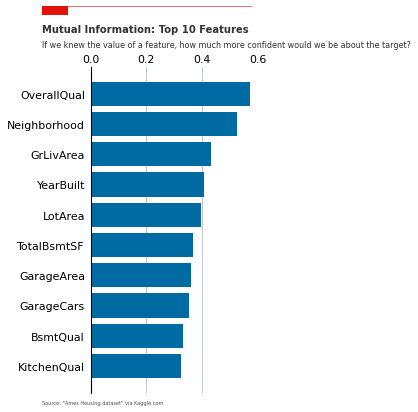

In [11]:
plot_mi_scores(mi_scores[:10])

In [12]:
print('Bottom 10:')
print(mi_scores[-10:])

Bottom 10:
Threeseasonporch    3.520758e-03
Condition2          8.473363e-04
Street              6.097767e-04
Utilities           1.887379e-15
PoolArea            2.220446e-16
PoolQC              0.000000e+00
MiscFeature         0.000000e+00
MiscVal             0.000000e+00
MoSold              0.000000e+00
YrSold              0.000000e+00
Name: MI Scores, dtype: float64


The features: [PoolQC, MiscFeature, MiscVal, MoSold, YrSold] are totally uninformative, and would make sense to drop.

In [13]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [14]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.14338026718687277

### Score (after dropping uninformative features): 0.14338 RMSLE

## Creating Features

As outlined in the [second tutorial](https://www.kaggle.com/code/ryanholbrook/creating-features), once we have restricted ourselves to the features that have any potential, we can create new features out of them. There were five basic strategies outlined in the tutorial:
* [Mathematical Transforms](https://www.kaggle.com/code/ryanholbrook/creating-features#Mathematical-Transforms): Relationships among numerical features expressed through mathematical formulas
* [Interaction with a Categorical (Sec.(2))](https://www.kaggle.com/code/abhirupghosh184098/exercise-creating-features)
* [Count feature](https://www.kaggle.com/code/ryanholbrook/creating-features#Counts): Features describing the presence or absence of something which can be aggregated by creating a count.
* [Building-Up and Breaking-Down Features](https://www.kaggle.com/code/ryanholbrook/creating-features#Building-Up-and-Breaking-Down-Features)
* [Group Transforms](https://www.kaggle.com/code/ryanholbrook/creating-features#Group-Transforms): transformations that aggregate information across multiple rows grouped by some category

and we explore each of them, one after the other.

**Caveats:** Things to keep in mind:
* data documentation
* domain knowledge
* previous work
* data visualisation

**IMPORTANT ADDITION**: Throughout this exercise, we also try incorporating the [suggestions for additional features](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=33) provided in the tutorial.

### Mathematical Transforms

Including:
* Square-roots of area features
* Logarithms for normalising skewed variables

In [15]:
# We'll focus on features describing areas -- 
# having the same units (square-feet) makes it easy 
# to combine them in sensible ways. Since we're using 
#XGBoost (a tree-based model), we'll focus on ratios and sums.

# Creating the following features:
# * LivLotRatio: the ratio of GrLivArea to LotArea
# * Spaciousness: the sum of FirstFlrSF and SecondFlrSF divided by TotRmsAbvGrd
# * TotalOutsideSF: the sum of WoodDeckSF, OpenPorchSF, EnclosedPorch, Threeseasonporch, and ScreenPorch

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd

    X["TotalOutsideSF"] = \
         df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
         df.Threeseasonporch + df.ScreenPorch
    
    # Suggestion 2: Square roots of area features. This would convert 
    # units of square feet to just feet.
    # https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=33
    # area_cols = [col for col in df.columns if col.endswith('Area')]
    
    #for col in area_cols:
    #    # Replacing Area with Length to denote appropriate units
    #    X[col.replace('Area', 'Length')] = np.sqrt(df[col])
        
    return X

        
def normalise_skew(df):        
    # Suggestion 3: Logarithms of numeric features. If a feature 
    # has a skewed distribution, applying a logarithm can help normalize it.
    # https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=33
    

    for col in df.select_dtypes("number").columns:
        # If the feature has 0.0 values, use np.log1p 
        # (log(1+x)) instead of np.log
        if 0 in df[col].unique():
            X[col] = np.log1p(df[col]) 
        else:
            X[col] = np.log(df[col])
    
    return X

print('Mathematical Transform:')
print('-----------------------')
#display(mathematical_transforms(df_train).head())
print('Normalise skewed distributions:')
print('-------------------------------')
#display(normalise_skew(df_train).head())

Mathematical Transform:
-----------------------
Normalise skewed distributions:
-------------------------------


#### [Suggestion 3](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=33)

Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it. Also, if the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log

---------------
Selected Plots:
---------------


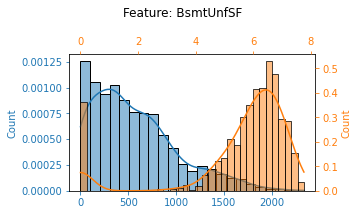

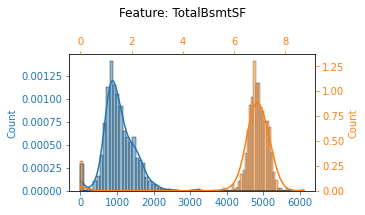

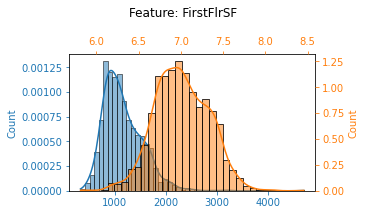

In [16]:
# Selected plots
print('---------------')
print('Selected Plots:')
print('---------------')

line_kws = {'color':'k'}

for col in df_train.select_dtypes("number").columns[7:10]:
    fig = plt.figure(figsize=(5,3), facecolor='white')
    ax1 = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)
    
    sns.histplot(df_train[col], ax=ax1, color='C0', kde=True, label="Original Data", stat='density')
    ax1.set_xlabel("")
    ax1.set_ylabel("Count", color="C0")
    ax1.tick_params(axis='x', colors="C0")
    ax1.tick_params(axis='y', colors="C0")
    
    if 0 in df_train[col].unique():
        sns.histplot(np.log1p(df_train[col]), ax=ax2, color='C1', kde=True, label="Logarithm", stat='density')
    else:
        sns.histplot(np.log(df_train[col]), ax=ax2, color='C1', kde=True, label="Logarithm", stat='density')
    ax2.set_xlabel("")
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Count', color="C1")       
    ax2.xaxis.set_label_position('top') 
    ax2.yaxis.set_label_position('right') 
    ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")
    
    fig.suptitle(f"Feature: {col}")
    plt.tight_layout()

    plt.show()

### Interaction with a categorical

In [17]:
# Creating a feature to capture the interaction we discovered 
# between BldgType and GrLivArea

def interactions(df):
    # One-hot encode BldgType. Use `prefix="Bldg"` in `get_dummies`
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    
    # One-hot encode Qual. Use `prefix="Qual"` in `get_dummies`
    # Suggestion 1: Interactions between the quality Qual and condition 
    # Cond features. OverallQual, for instance, was a high-scoring feature. 
    # We try combining it with OverallCond by converting both 
    # to integer type and taking a product.
    # https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=33
    
    # X = X.join(pd.Series(df['OverallQual'].cat.codes * df['OverallCond'].astype(str).astype(int), name='OverallQualCondInt'))
    
    # Suggestion 4: Interactions between numeric and categorical 
    # features that describe the same thing. We look at 
    # interactions between BsmtQual and TotalBsmtSF, for instance.
    
    # X1 = pd.get_dummies(df.BsmtQual, prefix="Bsmt")
    # X1 = X1.mul(df.TotalBsmtSF, axis=0)
    
    # X = X.join(X1)
    
    return X

#display(interactions(df_train).head())

#### [Suggestion 4](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=33)

Interactions between numeric and categorical features that describe the same thing. We look at interactions between BsmtQual and TotalBsmtSF, for instance.

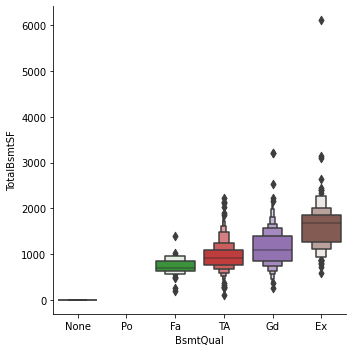

In [18]:
sns.catplot(x="BsmtQual", y="TotalBsmtSF", data=df_train, kind="boxen");

### Count feature

In [19]:
# Creating a feature that describes how many kinds of outdoor areas a dwelling has. 
# Options include: WoodDeckSF, OpenPorchSF, EnclosedPorch, Threeseasonporch, ScreenPorch

def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X

#display(counts(df_train).head())

### Breakdown/Buildup Features

In [20]:
def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X

#display(break_down(df_train).head())

### Group Transforms

In [21]:
# The value of a home often depends on how it compares to 
# typical homes in its neighborhood. Create a feature 
# MedNhbdArea that describes the median of GrLivArea grouped 
# on Neighborhood.

def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    
    # Suggestion 5: Other group statistics in Neighboorhood. 
    # We did the median of GrLivArea. Looking at mean, std, or count 
    # could be interesting. We could also try combining the group 
    # statistics with other features. Maybe the difference of 
    # GrLivArea and the median is important?
    # X["DiffNhbdArea"] = X["MedNhbdArea"] - df['GrLivArea']
    
    return X

#display(group_transforms(df_train).head())

### Label Encoding

[[Nice tutorial to Categorical Variables](https://www.kaggle.com/code/alexisbcook/categorical-variables/)]

**Disclaimer:** okay for tree-ensemble like XGBoost. For linear regression models, use OHE.

In [22]:
# Credit: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices?scriptVersionId=94830369&cellId=30

def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

#display(label_encode(df_train).head())

# Feature Discovery

As we had mentioned earlier, one can use unsupervised learning algorithms to learn hidden structures/patterns in the data and represent them as features. These techniques help 'discover' features, rather than create them what something pre-existing. The two predominant steps of feature engineering that deal with such feature discoveries are:

* Clustering using K-Means
* Principal Component Analyses

## Clustering using K-Means

**Clustering:** assigning of data points to groups based upon how similar the points are to each other. 

**K-means clustering:** measure the similarity using ordinary straight-line distance (Euclidean distance, in other words). It creates clusters by placing centroids inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates.



K-means clustering involves two steps:
* Scaling: The k-means algorithm is sensitive to scale; rule-of-thumb: rescale features not on comparable scales
* Clustering: We have two distinct ways to cluster:
  * Create a Feature of Cluster Labels: labelling each feature with the nearest cluster centroid (categorical feature)
  * Cluster-Distance Features: measure the distance from a point to all the centroids and return those distances as features (numeric feature).


In [23]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]

### Create a Feature of Cluster Labels

In [24]:
def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

#display(cluster_labels(df_train, cluster_features).head())

### Cluster-Distance Features

In [25]:
def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

#display(cluster_distance(df_train, cluster_features).head())

In [26]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


In [27]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

In [28]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

In [29]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

# Create Final Features

In [30]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Lesson 2 - Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    # Lesson 4 - Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.14053930286448071

In [31]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.12322296281029908

In [32]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2022-12-13 10:26:37,200] A new study created in memory with name: no-name-b2fae43d-fceb-4fa9-9781-0a108d5811c6
[I 2022-12-13 10:28:25,186] Trial 0 finished with value: 3.3718717613864646 and parameters: {'max_depth': 9, 'learning_rate': 0.0002131154523713172, 'n_estimators': 5968, 'min_child_weight': 3, 'colsample_bytree': 0.9579639101701511, 'subsample': 0.42939775195431545, 'reg_alpha': 82.12056413455501, 'reg_lambda': 0.021250540163386306}. Best is trial 0 with value: 3.3718717613864646.
[I 2022-12-13 10:30:09,491] Trial 1 finished with value: 0.12048289656999467 and parameters: {'max_depth': 3, 'learning_rate': 0.07946339185420749, 'n_estimators': 5046, 'min_child_weight': 4, 'colsample_bytree': 0.4594138524064175, 'subsample': 0.9153306854454217, 'reg_alpha': 0.09744552042138674, 'reg_lambda': 5.5130400664479735}. Best is trial 1 with value: 0.12048289656999467.
[I 2022-12-13 10:33:06,160] Trial 2 finished with value: 0.14350124180904616 and parameters: {'max_depth': 8, 'learni

In [33]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('submission_basic.csv', index=False)